In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import community
import networkx as nx
import sklearn
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import random
from sklearn.metrics import confusion_matrix
from networkx.generators.community import LFR_benchmark_graph
import networkx.generators.community 
from copy import deepcopy

In [ ]:
const_rand = 997

In [ ]:
def remove_from(
        v, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei):
    
    """
    Remove vertex from community
    v - vertex
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    ver_wei - sum of edges, that are connected to vertices
    """

    
    com_col = color[v]
    k_v = ver_wei[v]
    k_v_in = np.sum(G[v, np.where(color == com_col)])
    sum_ins[com_col] -= k_v_in
    sum_out[com_col] -= (k_v - k_v_in)
    return

In [ ]:
def add_to(
        v, to, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei):
    
    """
    Add vertex to community
    v - vertex, that we want to add
    to - vertex, to which community we want to add v
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    """

    com_col = color[to]
    sum_tot = sum_ins[com_col] + sum_out[com_col]
    k_v = ver_wei[v]
    k_v_in = np.sum(G[v, np.where(color == com_col)])
    first = (k_v_in / (2 * tot_mas))
    second = (sum_tot * k_v) / (2 * (tot_mas ** 2))
    add_ans = first - second
    k_v_out = k_v - k_v_in
    return add_ans, k_v_in, k_v_out

In [ ]:
def get_best_modularity(
        v, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei):

    """
    Find to which community we should add v
    v - vertex, that we want to add
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    """
    
    
    help_G = np.nonzero(G[v, :])[0]
    answer = np.zeros(len(help_G))
    if len(help_G) == 0:
        return v, 0, ver_wei[v]
    for i in range(len(help_G)):
        to = help_G[i]
        modularity, k_in, k_out = add_to(
            v, to, G, color, sum_ins, 
            sum_out, tot_mas, ver_wei)
        answer[i] = modularity
    if np.amax(answer) == 0:
        return -1, -1, -1
    result = np.where(answer == np.amax(answer))
    
    idi = random.randint(0, len(result[0]) - 1)
    
    to = help_G[result[0][idi]]
    mod, k_in, k_out = add_to(
        v, to, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei)
    
    return to, k_in, k_out

In [ ]:
def get_separation(
        G, color, sum_ins, sum_out, 
        tot_mas, ver_wei, rand_state = const_rand):

    """
    Find to which community we shuold add all vertices
    v - vertex, that we want to add
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """

    random = np.random.RandomState(rand_state)
    rand_order = np.arange(len(color))
    new_ans = np.copy(color)
    random.shuffle(rand_order)
    for i in rand_order:
        remove_from(
            i, G, new_ans, sum_ins, 
            sum_out, tot_mas, ver_wei)
        to, k_in, k_out = get_best_modularity(
            i, G, new_ans, sum_ins, sum_out, 
            tot_mas, ver_wei)
        if to == -1:
            continue
        color_to = new_ans[to]
        new_ans[i] = color_to
        sum_ins[color_to] += k_in
        sum_out[color_to] += k_out
    return new_ans

In [ ]:
def get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, rand_state = const_rand):

    """
    Count best partition
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """

    ans = np.copy(color)
    while True:
        new_ans = get_separation(
            G, ans, sum_ins, 
            sum_out, tot_mas, ver_wei, rand_state)
        if np.array_equal(ans, new_ans):
            return ans
        ans = new_ans

In [ ]:
def get_all_levels(G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, rand_state = const_rand):
    
    """
    Count all levels of partition
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """
    
    
    answer = get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei)
    while len(answer) != 1:
        index = {}
        for i in range(len(answer)):
            index[answer[i]] = index.get(answer[i], [])
            index[answer[i]].append(i)
        new_color = np.arange(len(index))
        n = len(new_color)
        
        
        dictionary = {}
        help_d = {}
        idi = 0
        for elem, lis in index.items():
            dictionary[idi] = dictionary.get(idi, lis)
            help_d[elem] = help_d.get(elem, idi)
            idi += 1
        
        new_G = np.zeros((n, n))
        for i in range(len(answer)):
            qwe = np.nonzero(G[i])
            indi = help_d[answer[i]]
            for j in qwe[0]:
                indj = help_d[answer[j]]
                if indi != indj:
                    new_G[indi][indj] += G[i][j]

        new_tot_mas = np.sum(new_G)
        new_sum_out = new_G.sum(axis = 1)
        new_sum_ins = np.zeros(len(new_G))
        new_ver_wei = new_G.sum(axis = 1)
        new_answer = get_new_level(
            new_G, new_color, new_sum_ins, 
            new_sum_out, new_tot_mas, new_ver_wei)
        print(dictionary)
        print()
        print(new_answer)
        print("_________________________")
        answer = new_answer
        color = new_color
        G = new_G
        tot_mas = new_tot_mas
        sum_out = new_sum_out
        sum_ins = new_sum_ins
        ver_wei = new_ver_wei
    
    return

In [ ]:
def pre_calc(G, color):
    
    """
    Calculate tot_mas, sum_ins, sum_out, ver_wei 
    G - adjacency matrix
    color - labels color
    """
    
    tot_mas = np.sum(G)
    ver_wei = np.sum(G, axis = 1)
    
    n = len(set(color))
    sum_ins = np.zeros(n)
    sum_out = np.zeros(n)
    for i in range(len(color)):
        com_col = color[i]
        i_in = np.sum(G[i, np.where(color == com_col)])
        sum_ins[com_col] += i_in
        i_out = np.sum(G[i, np.where(color != com_col)])
        sum_out[com_col] += i_out
    sum_ins /= 2
    return tot_mas, sum_ins, sum_out, ver_wei

In [ ]:
def make_joint_list(Matrixes, Colors, count):
    
    """
    Return list that will help to calculate joint clustering
    Matrixes - list of adjacency matrixes
    Colors - list of colors for matrixes
    count - number of matrixes, that we want to add to returning list
    """
    
    mat = []
    for i in range(count):
        hel = []
        hel.append(Matrixes[i])
        tot_mas, sum_ins, sum_out, ver_wei = pre_calc(Matrixes[i], Colors[i])
        hel.append(Colors[i])
        hel.append(tot_mas)
        hel.append(sum_ins)
        hel.append(sum_out)
        hel.append(ver_wei)
        mat.append(hel)
    return mat

In [ ]:
def joint_func(index_sum, modul_sum):
    
    """
    Function that returns vertex based on index_sum and modul_sum information
    index_sum - index_sum
    modul_sum - modul_sum
    """
    
    ind = np.nonzero(index_sum)[0]
    if len(ind) == 0:
        return -1
    for j in ind:
        modul_sum[j] /= index_sum[j]
    result = np.where(modul_sum == np.amax(modul_sum))
    idi = random.randint(0, len(result[0]) - 1)
    return result[0][idi]

In [ ]:
def get_joint_modularity(v, mat, index_sum, modul_sum):
    
    """
    Count all modularity for all matrix from vertex "v"
    v - vertex from we are going
    mat - list of matrix
    index_sum - index_sum
    modul_sum - modul_sum
    """
    
    G, color, tot_sum, sum_ins, sum_out, ver_wei = mat
    
    help_G = np.nonzero(G[v, :])[0]
    answer = np.zeros(len(help_G))
    if len(help_G) == 0:
        return
    for i in range(len(help_G)):
        to = help_G[i]
        modularity, k_in, k_out = add_to(
            v, to, G, color, sum_ins, 
            sum_out, tot_sum, ver_wei)
        index_sum[to] += 1
        modul_sum[to] += modularity
    return

In [ ]:
def get_joint_level(G, color, rand_state = const_rand):
    
    """
    Find to which community we shuold add all vertices
    G - list of adjacency matrices
    color - list, where will be answer
    rand_state - random_state
    """
    
    random = np.random.RandomState(rand_state)
    rand_order = np.arange(len(color))
    new_ans = np.copy(color)
    random.shuffle(rand_order)
    #print(G[0][1], sep = " ~ ")
    for i in rand_order:
        index_sum = np.zeros(len(color))
        modul_sum = np.zeros(len(color))
        v = i
        for mat in G:
            remove_from(v, mat[0], mat[1], mat[3], 
                mat[4], mat[2], mat[5])
            get_joint_modularity(v, mat, index_sum, modul_sum)
        to = joint_func(index_sum, modul_sum)
        if to == -1:
            continue
        #print(v, to, end = " | ")
        for mat in G:
            M, label, tot_sum, sum_ins, sum_out, ver_wei = mat
            mod, k_in, k_out = add_to(
                v, to, M, label, sum_ins, 
                sum_out, tot_sum, ver_wei)
            color_to = label[to]
            label[v] = color_to
            sum_ins[color_to] += k_in
            sum_out[color_to] += k_out
    new_ans = G[0][1]
    return new_ans

In [ ]:
def get_joint_cl(G, color, rand_state = const_rand):
    
    """
    Count joint partition
    G - list of adjacency matrices
    color - list, where will be answer
    rand_state - random_state
    """
    
    ans = np.copy(color)
    
    while True:
        new_ans = get_joint_level(
            G, color, rand_state)
        #print(new_ans)
        if np.array_equal(ans, new_ans):
            return ans
        ans = new_ans

In [ ]:
def modularity(part, G):
    
    """
    Count of modularity
    part - dictionary of vertex and color
    A - np.array
    """
    
    n = len(G[0])
    degrees = G.sum(axis=1)
    _sum = 0
    m = np.sum(G) / 2
    for i in range(n):
        for j in range(i + 1, n):
            if i == j:
                _sum -= ki * kj / m
            if part[i] == part[j]:
                ki = degrees[i]
                kj = degrees[j]
                _sum += (G[i][j] - ki * kj / (2 * m))
    for i in range(n):
        qwe = degrees[i]
        _sum -= qwe * qwe / (4 * m)
    return _sum / m

In [ ]:
def modularity_nx(part, A):
    
    """
    Count of modularity
    part - dictionary of vertex and color
    A - nx.Graph
    """
    
    G = nx.adjacency_matrix(A)
    n = len(part)
    _sum = 0
    m = np.sum(G) / 2
    for i in range(n):
        for j in range(i + 1, n):
            if part[i] == part[j]:
                ki = np.sum(G[i])
                kj = np.sum(G[j])
                _sum += (G[i,j] - ki * kj / (2 * m))
    for i in range(n):
        qwe = np.sum(G[i])
        _sum -= qwe * qwe / (4 * m)
    return _sum / (m)

In [ ]:
def make_dict(answer):
    
    """
    Make dictionary form list
    answer - list of colors
    """
    
#     dic = {i: answer[i] for i in range(len(answer))}
    return {i: answer[i] for i in range(len(answer))} #dict(zip(range(len(answer)), answer))

In [ ]:
def make_meta_graph(colors):
    
    """
    Make meta_graph form list of colors
    Returns matrix - meta graph (not symmetric)
    """
    
    colors = np.array(colors)
    n = colors.shape[1]
    row, col = np.triu_indices(n, k=1)
    meta_graph = np.zeros((n,n))
    for i,j in zip(row, col):
        meta_graph[i, j] = np.mean(colors[:, i] == colors[:, j])
        meta_graph[i, j] = meta_graph[i, j]
    return meta_graph

In [ ]:
def make_midle_graph(mats):
    
    """
    Make midle_graph form list of matrices
    Returns matrix - midle graph
    """
    
    n = mats.shape[1]
    ans = np.zeros((n, n))
    for i in mats:
        ans += i
    ans /= len(mats)
    return ans

In [ ]:
def generate_graphs_without(G, dell, non_z, num, pod_mat):
    
    """
    Generate matrices without some edges
    Returns list - np.array of matrices
    G - adjacency matrix
    dell - list of edges
    non_z - indeces of non zero edges
    num - number of edges, that we want to delete
    pod_mat - how many matrices we want to generate
    """
    
    mats = []
    for j in range(pod_mat):
        qwe = random.sample(list(dell), num)
        H = deepcopy(G)
        for el in qwe:
            H[non_z[0][el], non_z[1][el]] = 0
            H[non_z[1][el], non_z[0][el]] = 0
        mats.append(H)
    mats = np.array(mats)
    return mats

In [ ]:
pip install python-igraph

     |████████████████████████████████| 3.2MB 4.7MB/s 


In [ ]:
import igraph
from igraph import *

def numpy_array_to_igraph(mat, n):
    a = []
    for i in range(n - 1):
        for j in range(i + 1, n):
            qwe = (i, j, mat[i][j])
            a.append(qwe)
    edge = []
    weights = []
    # the loop for i is in range(5) because you have 5 edges
    for i in range(len(a)):
        for j in range(2):
            k = 2
            edge.append(a[i][j])
        weights.append(a[i][k])

    edges = [(i,j) for i,j in zip(edge[::2], edge[1::2])]

    list1 = []
    for i in range(len(edges)):
        list1.append((int(edges[i][0]), int(edges[i][1])))

    g = Graph()
    g.add_vertices(n)
    g.add_edges(list1)
    g.es['weight'] = weights
    return g, weights

In [ ]:
def get_nj_ans(mats, n, num):
    
    """
    Make not joint clustering
    Returns - answer
    mats - matrices
    n - number of verteces
    """
    
    '''colors = []
    for i in mats:
        g = nx.Graph(i)
        partition = community.best_partition(g, random_state = 997)        
        color1 = list(partition.values())
        ''''''color = np.arange(n)
        data = pre_calc(i, color)
        mid_color = get_new_level(i, color, data[1], data[2], data[0], data[3])''''''
        colors.append(color1)
    meta = make_meta_graph(colors)
    meta = np.array(meta)
    meta += meta.T
    midle_answer = nx.Graph(meta)
    partition = community.best_partition(midle_answer, random_state = 997)        
    color1 = list(partition.values())
    return color1'''

    colors = []
    for i in mats:
        '''color = np.arange(n)
        data = pre_calc(i, color)
        mid_color = get_new_level(i, color, data[1], data[2], data[0], data[3])'''
        g, w = numpy_array_to_igraph(i, n)
        cl = g.community_fastgreedy(w).as_clustering(num)
        answer = n * [0]
        for i in range(len(cl)):
            for j in cl[i]:
                answer[j] = i
        colors.append(answer)
    meta = make_meta_graph(colors)
    meta = np.array(meta)
    meta += meta.T
    g, w = numpy_array_to_igraph(meta, n)
    cl = g.community_fastgreedy(w).as_clustering(num)
    answer = n * [0]
    for i in range(len(cl)):
        for j in cl[i]:
            answer[j] = i
    return answer

In [ ]:
def real_dist(a, b, st):
    ans = 0
    for i in range(st):
        sq = (a[i] - b[i])**2
        ans += sq
    ans = ans**0.5
    return ans

In [ ]:
from sklearn.datasets import make_blobs


pod_mat = 5
n = 10
clusters = 3
feat = 3
x, y = make_blobs(n_samples=n, centers=clusters, n_features=feat, random_state=997)
G = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        G[i][j] = 1.0 / real_dist(x[i], x[j], feat)
g, w = numpy_array_to_igraph(G, n)
cl = g.community_fastgreedy(w).as_clustering(3)
answer = n * [0]
for i in range(len(cl)):
    for j in cl[i]:
        answer[j] = i
print(answer)
print(y)

[0, 0, 1, 2, 2, 1, 0, 1, 1, 2]
[2 2 0 1 1 0 2 0 0 1]


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from sklearn.datasets import make_blobs

pod_mat = 5
n = 1000
clusters = 50
feat = 3
total_ami1 = []
total_ami2 = []
total_ami3 = []
total_ari1 = []
total_ari2 = []
total_ari3 = []
for dsa in range(5):
    x, y = make_blobs(n_samples=n, centers=clusters, n_features=feat, random_state=997)
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            G[i][j] = 1.0 / real_dist(x[i], x[j], feat)
    '''G = nx.caveman_graph(40, 5)
    G = nx.to_numpy_matrix(G)'''
    non_z = np.nonzero(G)
    #answer = np.zeros(n)
    answer = y
    '''for i in range(n):
        answer[i] = i // 5'''
    m = len(non_z[0])
    dell = np.arange(m)
    ami1 = []
    ami2 = []
    ami3 = []
    ari1 = []
    ari2 = []
    ari3 = []
    for i in range(7 * (m // 10), 9 * (m // 10) + (m // 20) + 1, m // 100):
        #print(i, end = " | ")
        mats = generate_graphs_without(G, dell, non_z, i, pod_mat)
        
        color1 = np.arange(n)
        Colors = []
        for j in range(pod_mat):
            Colors.append(np.arange(n))
        my_answer = get_joint_cl(make_joint_list(mats, Colors, pod_mat), color1)
        
        #print("my_ok", end = " | ")
        
        color2 = np.arange(n)
        midle_graph = make_midle_graph(mats)
        data2 = pre_calc(midle_graph, color2)
        midle_answer = get_new_level(midle_graph, color2, data2[1], data2[2], data2[0], data2[3])
        
        #print("mid_ok", end = " | ")
        
        nj_answer = get_nj_ans(mats, n, clusters)
        
        #print("nj_ok", end = " | ")
        
        ari1.append(sklearn.metrics.adjusted_rand_score(my_answer, answer))
        ami1.append(sklearn.metrics.adjusted_mutual_info_score(my_answer, answer))
        ari2.append(sklearn.metrics.adjusted_rand_score(midle_answer, answer))
        ami2.append(sklearn.metrics.adjusted_mutual_info_score(midle_answer, answer))
        ari3.append(sklearn.metrics.adjusted_rand_score(nj_answer, answer))
        ami3.append(sklearn.metrics.adjusted_mutual_info_score(nj_answer, answer))
        #print("end", i)
    #print(ari1)
    #print(ami1)
    #print(ari2)
    #print(ami2)
    #print(ari3)
    #print(ami3)
    print(dsa, "ok")
    total_ami1.append(ami1)
    total_ami2.append(ami2)
    total_ami3.append(ami3)
    total_ari1.append(ari1)
    total_ari2.append(ari2)
    total_ari3.append(ari3)

0 ok
1 ok
2 ok
3 ok
4 ok


In [ ]:
f_ami1= open('total_ami1.txt', 'w')
for item in total_ami1:
    f_ami1.write("%s\n" % item)
f_ami1.close()

f_ami2= open('total_ami2.txt', 'w')
for item in total_ami2:
    f_ami2.write("%s\n" % item)
f_ami2.close()

f_ami3= open('total_ami3.txt', 'w')
for item in total_ami3:
    f_ami3.write("%s\n" % item)
f_ami3.close()

f_ari1= open('total_ari1.txt', 'w')
for item in total_ari1:
    f_ari1.write("%s\n" % item)
f_ari1.close()

f_ari2= open('total_ari2.txt', 'w')
for item in total_ari2:
    f_ari2.write("%s\n" % item)
f_ari2.close()

f_ari3= open('total_ari3.txt', 'w')
for item in total_ari3:
    f_ari3.write("%s\n" % item)
f_ari3.close()

In [ ]:
files.download('total_ami1.txt')
files.download('total_ami2.txt')
files.download('total_ami3.txt')
files.download('total_ari1.txt')
files.download('total_ari2.txt')
files.download('total_ari3.txt')

No handles with labels found to put in legend.


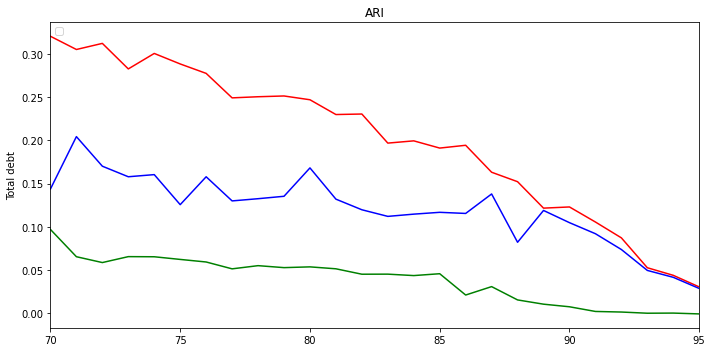

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
yrs = np.array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
ax.plot(yrs, total_ari1[2], color = 'red')
ax.plot(yrs, total_ari2[2], color = 'blue')
ax.plot(yrs, total_ari3[2], color = 'green')
ax.set_title('ARI')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()
 
plt.show()

No handles with labels found to put in legend.


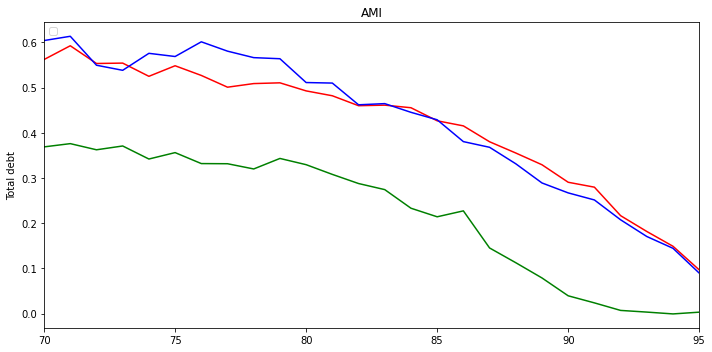

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
yrs = np.array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
ax.plot(yrs, total_ami1[4], color = 'red')
ax.plot(yrs, total_ami2[4], color = 'blue')
ax.plot(yrs, total_ami3[4], color = 'green')
ax.set_title('AMI')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()
 
plt.show()

[28 26 26 19 28 28 28 28 57 28 26 19 46 28 19 55 26 26 26 19 28 55 26 28
 46 26 26 28 28 28 46 28 28 28 41 26 59 57 41 41 41 41 57 41 59 41 46 41
 41 55 59 59 59 41 59 55 59 57 46 59 59 57 41 59 46 41 41 59]


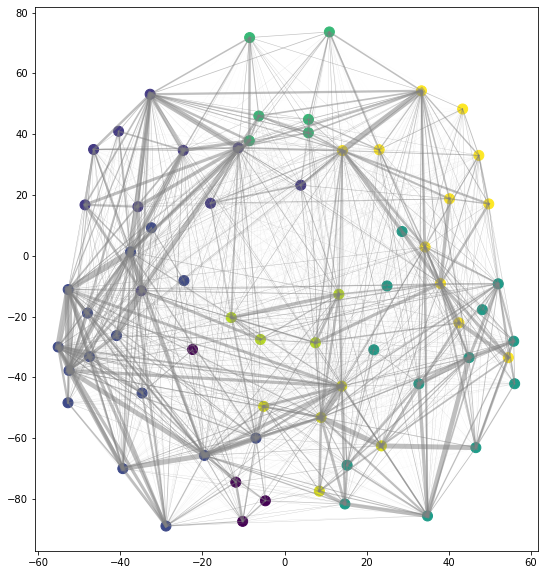

In [ ]:
a = np.array([[0, 9, 0, 0, 0, 0, 0, 0],
[9, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 9, 0, 0, 0, 0],
[0, 0, 9, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 9, 0, 0],
[0, 0, 0, 0, 9, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 9],
[0, 0, 0, 0, 0, 0, 9, 0]])
b = np.array([[0, 0, 0, 0, 0, 0, 0, 9],
[0, 0, 9, 0, 0, 0, 0, 0],
[0, 9, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 9, 0, 0, 0],
[0, 0, 0, 9, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 9, 0],
[0, 0, 0, 0, 0, 9, 0, 0],
[9, 0, 0, 0, 0, 0, 0, 0]])


color = np.arange(8)
Mat = []
Colors = []

'''Mat.append(a)
Mat.append(b)
Colors.append(color)
Colors.append(color)

'''
mats = np.load('E:/Ilnur/Telegram Desktop/adni', allow_pickle=True)
for i in range(807):
    color = np.arange(68)
    Colors.append(color)
    adj = mats[i]
    adj += adj.T
    np.fill_diagonal(adj, 0)
    Mat.append(adj)

color = np.arange(68)
qwe = make_joint_list(Mat, Colors, 807)
asd = get_joint_cl(qwe, color)
print(asd)

In [ ]:
# input

mats = np.load('E:/Ilnur/Telegram Desktop/adni', allow_pickle=True)
xyz = np.load('E:/Ilnur/Telegram Desktop/adni_centers', allow_pickle=True)

i = 10
coords = xyz[i]
adj = mats[i]
adj += adj.T
np.fill_diagonal(adj, 0)
#n = int(input())
G = adj
color = np.arange(len(adj))

In [ ]:
#pre_calc
tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)

In [ ]:
#answer = get_new_level(
#        G, color, sum_ins, 
#       sum_out, tot_mas, ver_wei)
get_all_levels(G, color, sum_ins, 
       sum_out, tot_mas, ver_wei)
#print(ans)

{0: [0, 3, 4, 5, 6, 7, 9, 11, 13, 14, 19, 23, 27, 31], 1: [1, 2, 10, 12, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 30], 2: [8, 28, 29, 32, 33, 42], 3: [34, 36, 40, 47, 49, 50, 51, 52, 54, 56, 57, 61, 62, 63, 66, 67], 4: [35, 44, 46, 55, 58, 59, 60, 64], 5: [37, 38, 39, 41, 43, 45, 48, 53, 65]}

[2 2 2 5 5 5]
_________________________
{0: [0, 1, 2], 1: [3, 4, 5]}

[0 0]
_________________________
{0: [0, 1]}

[0]
_________________________


In [ ]:
#Get_ans
mats = np.load('E:/Ilnur/Telegram Desktop/adni', allow_pickle=True)
xyz = np.load('E:/Ilnur/Telegram Desktop/adni_centers', allow_pickle=True)

sum1 = 0
sum2 = 0
for i in range(10):
    coords = xyz[i]
    adj = mats[i]
    adj += adj.T
    np.fill_diagonal(adj, 0)
    
    
    G = adj
    color = np.arange(len(adj))
    
    tot_mas = np.sum(G)
    sum_out = G.sum(axis = 1)
    sum_ins = np.zeros(len(G))
    ver_wei = G.sum(axis = 1)
    answer = get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, 997)
    
    g = nx.Graph(adj)
    
    partition = community.best_partition(g, random_state = 997)
    my_partition = make_dict(answer)
    
    color1 = list(partition.values())
    C = confusion_matrix(color1, answer)
    
    
#print(answer)
    
    sum1 += sklearn.metrics.adjusted_rand_score(color1, answer)
    sum2 += sklearn.metrics.adjusted_mutual_info_score(color1, answer)
print()
print(sum1 / 10, sum2 / 10)
#color1 = list(partition.values())
#print(color1)
#sklearn.metrics.adjusted_rand_score(color1, answer)
#sklearn.metrics.adjusted_mutual_info_score(answer, color1)


0.6763711420875687 0.7946554438425222


In [ ]:
import matplotlib.pyplot as plt

n = [250, 500]
tau1 = 3
tau2 = 1.1
mu = 0.1
M = LFR_benchmark_graph(n[0], tau1, tau2, mu, average_degree=10,
                        max_degree = 20, min_community=10, max_community = 20, seed=10)

gg=M.copy()   #Here I want to copy
#nx.drawing.draw(M)
adj = nx.to_numpy_matrix(M)
adj = np.array(adj)
adj += adj.T
np.fill_diagonal(adj, 0)

G = adj
color = np.arange(len(adj))

tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)


answer = get_new_level(
    G, color, sum_ins, 
    sum_out, tot_mas, ver_wei, 997)
g = nx.Graph(adj)

partition = community.best_partition(g, random_state = 997)
my_partition = make_dict(answer)

color1 = list(partition.values())

print(sklearn.metrics.adjusted_rand_score(color1, answer))

print(sklearn.metrics.adjusted_mutual_info_score(color1, answer))

1.0
1.0


In [ ]:
sum1 = 0
sum2 = 0
adj += adj.T
np.fill_diagonal(adj, 0)
G = adj
color = np.arange(len(adj))

tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)
Q = 0
answer = get_new_level(
    G, color, sum_ins, 
    sum_out, tot_mas, ver_wei, 997)

g = nx.Graph(adj)
partition = community.best_partition(g, random_state = 997)
#print(Q, community.modularity(partition, g))
color1 = list(partition.values())
C = confusion_matrix(color1, answer)


#print(answer)

sum1 += sklearn.metrics.adjusted_rand_score(color1, answer)
sum2 += sklearn.metrics.adjusted_mutual_info_score(color1, answer)

print(sum1, sum2)

1.0 1.0


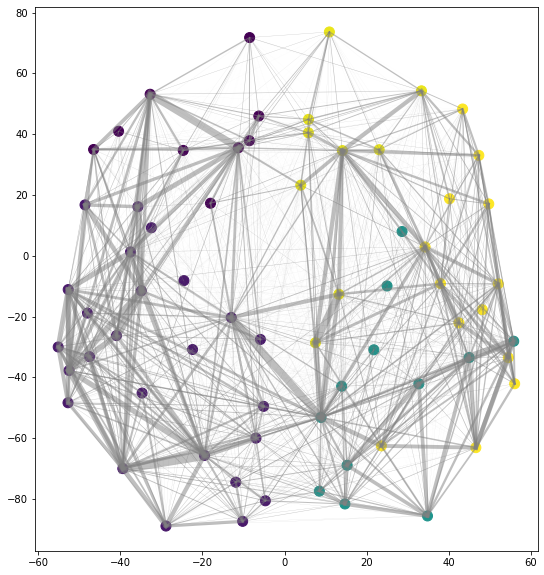

In [ ]:
plt.figure(figsize=(9,10))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=answer)
for x in range(68):
    for y in range(x, 68):
        plt.plot([coords[x, 0], coords[y, 0]], [coords[x, 1], coords[y, 1]],
                 lw = .001*adj[x, y], alpha=.5, c='gray')